# Neutron Burst

The neutron burst may happen in high mass stars during a supernova blast leaving behind characteristic nucleosynthesis signatures in presolar grains. The neutron burst occurs when neutron number densities are sufficiently high ($\sim 10^{17}$ neutrons/cm$^{-3}$) to capture up an isotopic chain in a manner similar to the r-process, though with much lower neutron exposures and therefore less neutron rich products. 

For a glipse at this kind of network, consider the following neutron capture chain:
\begin{gather}
1 + n \rightarrow 2 + \gamma\notag\\
2 + n \rightarrow 3 + \gamma\notag\\
3 + n \rightarrow 4 + \gamma\notag
\end{gather}

To solve this network numerically we have the coupled differential equations:
\begin{gather}
\frac{dY_1}{d\tau} = -\sigma_{n,1} Y_1\\
\frac{dY_2}{d\tau} = \sigma_{n,1} Y_1 - \sigma_{n,2}Y_2\\
\frac{dY_3}{d\tau} = \sigma_{n,2} Y_2 - \sigma_{n,3}Y_3\\
\frac{dY_4}{d\tau} = \sigma_{n,3} Y_3 
\end{gather}
where the $\sigma_n$ are the neutron capture cross sections for each species and $\tau$ is the neutron exposure (units of inverse area). 

For simplicity, this notebook considers an isolated reaction chain. In other words the only reactions considered are neutron captures along the chain and out of the chain.

## Preliminaries 

We begin by importing the necessary libraries:

In [54]:
import sys, subprocess, pkg_resources
import os, io, requests
required = {'numpy','wnutils', 'wnnet', 'matplotlib', 'gslconsts', 'scipy', 'ipywidgets', 'xmlcoll'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import wnnet as wn 
import wnutils.xml as wx
import xmlcoll as xc
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
from gslconsts.consts import *
from scipy.integrate import solve_ivp

Now we define a function to integrate the network numerically:

In [55]:
def dYdt(t, y, sigs):
    N = len(y)
    result = np.zeros(N)
    result[0] = -sigs[0]*y[0]
    for i in range(1, N):
        result[i] = sigs[i-1]*y[i-1] - sigs[i]*y[i]
    return result

Additionally to get the initial abundances, we will rely on a solar xml file. The following is a function to read in the desired abundance data from a solar xml file:

In [56]:
def get_solar_isotopes(isotopes):    
    solar_data = solar_xml.get_zone_data()
    x_solar = solar_data["0"]["mass fractions"]

    abunds = []
    a = []
    d = {}

    for isotope in isotopes:
        tup = solar_xml.get_z_a_state_from_nuclide_name(isotope)
        s_tup = (isotope, tup[0], tup[1])
        if s_tup in x_solar:
            a.append(s_tup[2])
            abunds.append(x_solar[s_tup] / tup[1])
            d[s_tup[0]] = x_solar[s_tup] / tup[1]
        else:
            abunds.append(0)
            d[s_tup[0]] = 0
            
    return a, d, abunds

Now, we import the data that will be used throughout this notebook. Execution of this cell will take a minute. The 'solar_xml' contains the mass fractions of isotopes in the solar system and the 'net' contains details on nuclear reaction rates for computing the neutron burst network. 

In [57]:
solar_xml = wx.Xml(io.BytesIO(requests.get("https://osf.io/j67qa/download").content))
net = wn.net.Net(io.BytesIO(requests.get('https://osf.io/vqhxr/download').content))

XMLSyntaxError: Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)

### Getting the initial abundances
Now we define a list of isotopes.  This is our network. 

In [ ]:
#species = ['ca40','ca41','ca42','ca43','ca44','ca45','ca46','ca47','ca48','ca49','ca50']
species = ['ni55','ni56','ni57','ni58','ni59','ni60','ni61','ni62','ni63','ni64']
element = 'Ni'
a_species = []
for sp in species:
    z_a_state = solar_xml.get_z_a_state_from_nuclide_name(sp)
    a_species.append(z_a_state[1])

Now we use the get_solar_isotopes function to populate the abundance dictionary. The keys will be the isotope names and the value will be the abundances:

In [58]:
a_solar, d_solar, solar_abunds = get_solar_isotopes(species)
    
isotope_abunds = np.zeros(len(species))
for k, v in d_solar.items():
    isotope_abunds[species.index(k)] = v

Finally, we can plot the initial abundances. It is best to plot the ratios normalized to some isotope. For this example we choose $^{58}$Ni, but one should change this depending on their inputted nuclear network:

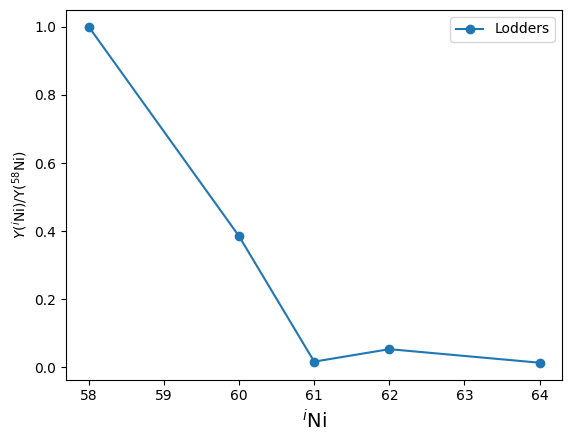

In [59]:
normalizing_species = 'ni58'
fig, ax = plt.subplots()
normalized_solar = []
for abunds in solar_abunds:
    if abunds != 0:
        normalized_solar.append(abunds/d_solar['ni58'])
ax.plot(a_solar, normalized_solar, 'o-', label = 'Lodders')
ax.set_xlabel(fr'$^i ${element}', fontsize = 14)
ax.set_ylabel(fr'$Y$($^i${element})/Y({solar_xml.get_latex_names([normalizing_species])[normalizing_species]})') 
ax.legend()
plt.show()

### Plotting the abundances for varying exposures

We can use the initial abundances and the scipy.integrate function to solve the system of ODE's presented above. In order to do this we need to obtain the neutron capture cross sections ($\sigma_i$) using the wnnet package. 

First, we define a temperature in $10^9$K to be used to compute the reaction rates.

In [60]:
t9 = .7

Now, we compute the reaction rates for all neutron capture reactions at the provided temperature:

In [61]:
induced_reac_xpath = "[reactant = 'n' and product = 'gamma']"
reacs = net.compute_rates(t9, reac_xpath = induced_reac_xpath)
rates = []
for key, values in list(reacs.items()):
    rates.append(values[0])

Next, we can obtain a dictionary of the reactions for strictly the species in our reaction chain: 

In [62]:
ordered_dict = {}

for sp in species:
    for key, value in net.get_reactions(reac_xpath = induced_reac_xpath).items():
        if sp in value.reactants:
            ordered_dict[sp] = reacs[key][0]

Now that we have obtained the rates, we can get the cross sections by noting:
\begin{gather}
r(T) = N_A <\sigma v>(T)
\end{gather}
and the thermal velocity is given by:
\begin{gather}
v_T = \sqrt{\frac{2k_BT}{m_n}}
\end{gather}
which represents the most probable velocity in a Maxwell-Boltzmann distribution. We then compute the cross sections:

In [63]:
k = GSL_CONST_CGS_BOLTZMANN
N_A = GSL_CONST_NUM_AVOGADRO
m_n = GSL_CONST_CGS_MASS_NEUTRON

T = t9 * 10**9
v_T = np.sqrt((2*k*T)/m_n)

sigs_array = []
for key, value in ordered_dict.items():
    sigs_array.append(1000*value/(v_T*N_A*GSL_CONST_CGSM_BARN))

Now we have all the components needed to solve the neutron burst. However, one would like to compare the results to grain data. To do this we create a dictionary of presolar grain data:

In [64]:
grains = [
    {'name': 'grain 1',
     'a': [60, 61, 62, 63, 64],
     'data': [1.44, 9.25, 9.02, 6.58, 22.27],
     'error': [0.07, 0.81, 0.50, 0.36, 1.29]
    }
]

for g in grains:
    assert len(g['a']) == len(g['data']) == len(g['error'])

This data is presented in the form of Ratios/Solar where the ratios relative to the normalizing species defined earlier. Now we can explore the abundances with varying exposures. The following is an interactive plot where one can change the value of the exposure with the floating text box. Grain data can be optionally displayed with the checkbox: 

In [65]:
def plot_nuclear_network(tau, abunds, show_grain):

    sol = solve_ivp(dYdt, (0, tau), abunds, args=(sigs_array,), max_step=0.001)
    f = d_solar[normalizing_species]/sol.y[species.index(normalizing_species),-1]
    sol_normalized = []
    for i in range(len(sol.y)):
        if solar_abunds[i] != 0:
            sol_normalized.append(sol.y[i,-1]/solar_abunds[i])

    fig, ax = plt.subplots() 
    ax.plot(a_solar, sol_normalized, 'o-', label = 'Network')
    if show_grain == True:
        for i in range(len(grains)):
            ax.errorbar(grains[i]['a'], grains[i]['data'], yerr = grains[i]['error'], label = grains[i]['name'])
    #ax.set_xticks(range(min(a), max(a) + 1, 1))
    ax.set_xlabel(fr'$^i{element}$')  #Modify element symbol for different abundance chain
    ax.set_ylabel('Ratios/Solar')
    ax.set_title('$\\tau$ = {:.3f} $mb^{{-1}}$'.format(tau))
    ax.legend()
    plt.show()
    ax.clear()

interact(
    plot_nuclear_network,
    tau=widgets.BoundedFloatText(value=0.01, min=0.0, max=0.3, step=0.01, description='τ'),
    abunds=fixed(isotope_abunds),
    show_grain = widgets.Checkbox(value = False, description = "Display Grain Data")
)

interactive(children=(BoundedFloatText(value=0.01, description='τ', max=0.3, step=0.01), Checkbox(value=False,…

<function __main__.plot_nuclear_network(tau, abunds, show_grain)>